# Tendon Gliding Hand Action Recognition

# Description

- The goal is to perform Tendon Gliding Hand Action Recognition by classifying hand postures into five distinct classes using real-time video. Additionally, the task involves calculating the accuracy of hand skeleton occurrences compared to the ground truth.
- The classes are as follows: **Hand Open**, **Intrinsic Plan**, **Straight Fist**, **Hand Close**, and **Hook Hand**.  

<p align="center">
    <img src='../../IMAGES/Classes.jpg' width="500px" />
</p>

- The base workflow is as follows: 

<div align="center">

```mermaid
graph LR
    A[Import RAW Data]
    A --> B[Separate into 5 different classes]
    B --> C[Generate 2D keypoints of X and Y coordinates]
    C --> D[Train LSTM model]
    D --> E[Evaluate Performance]
    E --> F[Metrics: Accuracy, Specificity, Sensitivity, F1-Score, Confusion Matrix]
```

</div>

## 0. Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import rerun as rr
import rerun.blueprint as rrb
import seedir as sd
import os
import albumentations as A
from pyorbbecsdk import *
import cv2
from utils import frame_to_bgr_image
from pathlib import Path
import shutil
from collections import defaultdict

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"

D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\albumentations\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1. Utility Function

In [101]:
def list_bag_files(root_dir='data'):
    """
    List all .bag files in the directory structure, excluding those in 'open-hand' folders.
    
    Args:
        root_dir (str): Root directory to start the search from.
        
    Returns:
        list: List of paths to .bag files.
    """
    bag_files = []
    
    for root, dirs, files in os.walk(root_dir):
        # Skip 'open-hand' directories
        if 'open-fist' in os.path.basename(root):
            continue
            
        # Add .bag files to the list
        for file in files:
            if file.endswith('.bag'):
                bag_files.append(os.path.join(root, file))
                
    return bag_files

def playback_state_callback(state):
    """Callback function to handle playback state transitions."""
    global playback_finished
    if state == OBMediaState.OB_MEDIA_BEGIN:
        print("Bag player begin")
    elif state == OBMediaState.OB_MEDIA_END:
        print("Bag player end")
        playback_finished = True  # Signal that playback has finished
    elif state == OBMediaState.OB_MEDIA_PAUSED:
        print("Bag player paused")

def process_frames(bag_file):
    """
    Process the .bag file and return lists of processed images.
    
    Returns:
        depth_image_list: List of raw depth data (converted to float and scaled).
        color_image_list: List of processed color images.
        overlaid_image_list: List of images with overlay (color blended with depth colormap).
    """
    global playback_finished
    playback_finished = False  # Reset flag

    pipeline = Pipeline(bag_file)
    playback = pipeline.get_playback()
    playback.set_playback_state_callback(playback_state_callback)

    # Start the pipeline
    pipeline.start()

    depth_image_list = []
    color_image_list = []

    while not playback_finished:
        frames = pipeline.wait_for_frames(100)
        if frames is None:
            if playback_finished:
                print("All frames have been processed and converted successfully.")
                break
            continue

        # Retrieve frames once per iteration
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()

        if depth_frame is not None:
            width = depth_frame.get_width()
            height = depth_frame.get_height()
            scale = depth_frame.get_depth_scale()

            # Process raw depth data
            depth_data = np.frombuffer(depth_frame.get_data(), dtype=np.uint16)
            depth_data = depth_data.reshape((height, width))
            depth_data = depth_data.astype(np.float32) * scale
            depth_image_list.append(depth_data)

            # Normalize and invert to obtain desired mapping (farthest = red, closest = blue)
            depth_norm = cv2.normalize(depth_data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            inverted_depth = 255 - depth_norm
            depth_image = cv2.applyColorMap(inverted_depth, cv2.COLORMAP_JET)
        else:
            depth_image = None

        if color_frame is not None:
            width = color_frame.get_width()
            height = color_frame.get_height()

            color_data = frame_to_bgr_image(color_frame)
            color_image = cv2.resize(color_data, (width, height))
            # Convert to BGR if necessary; adjust if frame_to_bgr_image already outputs BGR
            color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
            color_image_list.append(color_image)
        else:
            color_image = None

    return depth_image_list, color_image_list

def rerun_visualization(*image_lists):
    """
    Create a rerun visualization with multiple image lists displayed in a grid.
    
    Args:
        *image_lists: Variable number of image lists to display
    """
    stream = rr.new_recording("spawn", spawn=True)
    
    # Dynamically create spatial views for each image list
    spatial_views = []
    for i in range(len(image_lists)):
        spatial_views.append(rrb.Spatial2DView(origin=f'/color_image_{i}'))
    
    # Calculate a reasonable number of columns for the grid
    # You can adjust this logic based on your preference
    num_columns = min(3, len(image_lists))  # Max 3 columns
    
    # Setup the blueprint with dynamic grid configuration
    blueprint = rrb.Blueprint(
        rrb.Grid(*spatial_views, grid_columns=num_columns),
        collapse_panels=True
    )
    
    # Calculate the maximum length across all image lists
    max_length = max(len(image_list) for image_list in image_lists)
    
    # Log all images with proper time sequencing
    for idx in range(max_length):
        stream.set_time_sequence("frame", idx)
        
        # Log each image list at the current index if available
        for list_idx, image_list in enumerate(image_lists):
            if idx < len(image_list):
                stream.log(f"color_image_{list_idx}", rr.Image(image_list[idx]))
    
    stream.send_blueprint(blueprint)

def sliding_window_sample(images, window_size=16, stride=8):
    total_frames = len(images)
    windows = []
    
    for start_idx in range(0, total_frames - window_size + 1, stride):
        end_idx = start_idx + window_size
        window = np.stack(images[start_idx:end_idx])
        windows.append(window)
    
    return windows

def visualize_windows(windows):
    """
    Visualize multiple windows of image sequences in Rerun.
    
    Args:
        windows: List of image windows, where each window is a sequence of frames
        max_windows_to_display: Maximum number of windows to display in the grid
    """
    stream = rr.new_recording("spawn", spawn=True)
    
    # Limit the number of windows to display to avoid overcrowding
    num_windows = len(windows)
    
    # Create spatial views for each window
    spatial_views = []
    for i in range(num_windows):
        spatial_views.append(rrb.Spatial2DView(origin=f'/window_{i}'))
    
    # Calculate grid layout (max 3 columns)
    num_columns = min(3, num_windows)
    
    # Setup the blueprint with dynamic grid configuration
    blueprint = rrb.Blueprint(
        rrb.Grid(*spatial_views, grid_columns=num_columns),
        collapse_panels=True
    )
    
    # Log the frames of each window
    window_size = windows[0].shape[0]  # Get the size of each window
    
    # Log each frame in each window
    for frame_idx in range(window_size):
        stream.set_time_sequence("frame", frame_idx)
        
        # Log the current frame from each window
        for window_idx in range(num_windows):
            if window_idx < len(windows):
                stream.log(f"window_{window_idx}", 
                          rr.Image(windows[window_idx][frame_idx]))
    
    # Display info about the windows
    print(f"Visualizing {num_windows} windows out of {len(windows)} total")
    print(f"Each window contains {window_size} frames")
    print(f"Window shape: {windows[0].shape}")
    
    stream.send_blueprint(blueprint)

def save_windowed_data(recordings, bag_files, window_size=16, stride=8, windowed_data_dir='windowed_data'):
    """
    Save windowed data for RGB and depth images for each recording to its respective folder.
    
    Args:
        recordings: Dictionary containing recordings with color_images and depth_images
        bag_files: List of bag file paths sorted to match recording indices
        window_size: Size of each window
        stride: Stride between consecutive windows
    """
    print(f"Saving windowed data for {len(recordings)} recordings...")
    
    for recording_idx, bag_file_path in enumerate(bag_files):
        recording_key = f"recording_{recording_idx}"
        
        # Check if the recording exists
        if recording_key in recordings:
            recording_data = recordings[recording_key]
            # Create base output directory for this recording
            bag_path = Path(bag_file_path)
            base_output_dir = bag_path.parent / windowed_data_dir
            
            # Process each image type (RGB and depth)
            image_types = {
                "color_images": "rgb",
                "depth_images": "depth"
            }
            
            for image_key, folder_name in image_types.items():
                if image_key in recording_data and recording_data[image_key] is not None:
                    images = recording_data[image_key]
                    
                    # Create windows for this image type
                    windows = sliding_window_sample(images, window_size=window_size, stride=stride)
                    
                    # Create output directory for this image type
                    output_dir = base_output_dir / folder_name
                    os.makedirs(output_dir, exist_ok=True)
                    
                    # Create a base filename from the bag file
                    base_filename = bag_path.stem
                    
                    # Save each window as a separate .npy file
                    for window_idx, window in enumerate(windows):
                        # Create filename: RecordXXX_window_NNN.npy
                        window_filename = f"{base_filename}_window_{window_idx:03d}.npy"
                        output_path = output_dir / window_filename
                        
                        # Save the window data
                        np.save(output_path, window)
                    
                    print(f"Saved {len(windows)} {folder_name} windows for {recording_key} to {output_dir}")
                else:
                    print(f"Skipping {image_key} for {recording_key}: Data not available")
        else:
            print(f"Skipping recording {recording_idx}: Recording not found")
    
    print("Windowed data saving complete!")

def prepare_recordings_dict(processed_data):
    recordings = {}
    for i in range(6):  # Assuming there are 6 recordings (0-5)
        recording_key = f"recording_{i}"
        if recording_key in processed_data:
            recordings[recording_key] = processed_data[recording_key]
    return recordings

## 2. Data Preparation

- In total there are six different recordings of tendon gliding task as follows: 
    - From 📁 `20250402`
        - `Record_20250402151124.bag`
        - `Record_20250402151609.bag`
        - `Record_20250402152331.bag`
    - From 📁 `20250506`
        - `Record_20250506145704.bag`
        - `Record_20250506152951.bag`
        - `Record_20250506162630.bag`
- Each data consist of RGB frames and Depth frames
- Workflow: 

<div align="center">

```mermaid
graph LR
    A[Data Extraction] --> B[Data Visualization]
    B --> C[Windowing Process]
    C --> D[Save Windowed Data]
    D --> E[Data Class Generation]
```

</div>

**Data Extraction**

In [3]:
bag_files = list_bag_files()
data_20250402 = bag_files[:3]      # First three items
data_20250506 = bag_files[-3:]     # Last three items
processed_data = {}

# Process the 20250402 files
for idx, bag_file in enumerate(data_20250402):
    print(f"Processing bag file: {bag_file}")
    # Process the frames in the bag file
    depth_images, color_images = process_frames(bag_file)
    # Store the lists in the dictionary with dataset identifier
    processed_data[f"recording_{idx}"] = {
        "dataset": "20250402",
        "depth_images": depth_images,
        "color_images": color_images
    }

# Process the 20250506 files
for idx, bag_file in enumerate(data_20250506):
    print(f"Processing bag file: {bag_file}")
    # Process the frames in the bag file
    depth_images, color_images = process_frames(bag_file)
    # Store the lists in the dictionary with dataset identifier
    processed_data[f"recording_{idx+3}"] = {  # Add offset to avoid key collision
        "dataset": "20250506",
        "depth_images": depth_images,
        "color_images": color_images
    }

Processing bag file: data\20250402\Record_20250402151124.bag
Bag player begin
Bag player end
Processing bag file: data\20250402\Record_20250402151609.bag
Bag player begin
Bag player end
Processing bag file: data\20250402\Record_20250402152331.bag
Bag player begin
Bag player end
Processing bag file: data\20250506\T2\tendon-gliding\Record_20250506145704.bag
Bag player begin
Bag player end
Processing bag file: data\20250506\T3\tendon-gliding\Record_20250506152951.bag
Bag player begin
Bag player end
Processing bag file: data\20250506\T4\tendon-gliding\Record_20250506162630.bag
Bag player begin
Bag player end


**Data Visualization**

In [4]:
recording_0 = processed_data.get("recording_0")
recording_1 = processed_data.get("recording_1")
recording_2 = processed_data.get("recording_2")
recording_3 = processed_data.get("recording_3")
recording_4 = processed_data.get("recording_4")
recording_5 = processed_data.get("recording_5")

image_lists = []
for recording_idx in range(6):  # Assuming you have 6 recordings
    recording_key = f"recording_{recording_idx}"
    if recording_key in processed_data and "color_images" in processed_data[recording_key]:
        image_lists.append(processed_data[recording_key]["color_images"])

# Visualize all valid image lists together
if image_lists:
    rerun_visualization(*image_lists)

**Detect Hand**

In [ ]:
import os
import numpy as np
import mmcv
from mmdet.apis import inference_detector, init_detector
from mmpose.utils import adapt_mmdet_pipeline
from mmpose.evaluation.functional import nms
import warnings
import logging

# Global model cache to avoid reloading models
_MODEL_CACHE = {}

def detect_hands(img, 
                det_config='configs/rtmdet_nano_320-8xb32_hand.py',
                det_checkpoint='https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_nano_8xb32-300e_hand-267f9c8f.pth',
                device='cuda:0',
                det_cat_id=0,
                bbox_thr=0.3,
                nms_thr=0.3,
                suppress_warnings=True,
                input_size=(300, 300),
                crop_size=(600, 600),
                return_coordinates='original'):
    """
    Detect hand bounding boxes in an image.
    
    Args:
        img: Image path or numpy array (RGB).
        det_config: Path to detection config file.
        det_checkpoint: Path or URL to detection checkpoint.
        device: Device to run inference on.
        det_cat_id: Category ID for hands.
        bbox_thr: Threshold for bounding box confidence.
        nms_thr: Threshold for non-maximum suppression.
        suppress_warnings: Whether to suppress warning messages.
        input_size: Model input size (width, height), defaults to (300, 300)
        crop_size: Size for center crop (width, height), defaults to (600, 600)
        return_coordinates: Coordinate system for returned bounding boxes:
                          - 'original': In original input image coordinates (default)
                          - 'crop': In center-cropped image coordinates
                          - 'model': In model input size coordinates (300x300 by default)
        
    Returns:
        bboxes: Numpy array of hand bounding boxes [x1, y1, x2, y2] in specified coordinate system
        scores: Numpy array of confidence scores
        crop_info: Dictionary with information about the crop (for transforming coordinates)
        processed_img: The cropped or model-sized image based on return_coordinates value
    """
    global _MODEL_CACHE
    
    # Validate return_coordinates parameter
    valid_return_options = ['original', 'crop', 'model']
    if return_coordinates not in valid_return_options:
        raise ValueError(f"return_coordinates must be one of {valid_return_options}, got {return_coordinates}")
    
    # Set up warning suppression if requested
    if suppress_warnings:
        # Filter warnings
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=FutureWarning)
        
        # Filter mmengine and other library logs
        logging.getLogger('mmengine').setLevel(logging.ERROR)
        logging.getLogger('mmdet').setLevel(logging.ERROR)
        logging.getLogger('mmpose').setLevel(logging.ERROR)
        
        # Disable PyTorch CUDA warnings
        os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
    
    # Check if model is already in cache
    model_key = f"{det_config}_{det_checkpoint}_{device}"
    if model_key not in _MODEL_CACHE:
        # Build detector
        detector = init_detector(det_config, det_checkpoint, device=device)
        detector.cfg = adapt_mmdet_pipeline(detector.cfg)
        _MODEL_CACHE[model_key] = detector
    else:
        detector = _MODEL_CACHE[model_key]
    
    # Convert image to numpy array if it's a path
    if isinstance(img, str):
        img = mmcv.imread(img, channel_order='rgb')
    elif isinstance(img, np.ndarray) and img.shape[-1] == 3:
        # Convert BGR to RGB if necessary
        if not isinstance(img, np.ndarray):
            img = np.array(img)
        img = mmcv.bgr2rgb(img)
    
    # Store original image dimensions
    original_height, original_width = img.shape[:2]
    
    # Apply center crop first to get the cropped image
    center_crop = A.CenterCrop(height=crop_size[1], width=crop_size[0])
    crop_result = center_crop(image=img)
    cropped_img = crop_result['image']
    
    # Calculate actual crop offsets based on original image dimensions
    crop_x_offset = max(0, (original_width - crop_size[0]) // 2)
    crop_y_offset = max(0, (original_height - crop_size[1]) // 2)
    
    # Now resize the cropped image to input size for the model
    resize_transform = A.Resize(height=input_size[1], width=input_size[0])
    resize_result = resize_transform(image=cropped_img)
    processed_img = resize_result['image']
    
    # Store crop information for coordinate mapping
    crop_info = {
        'original_size': (original_width, original_height),
        'crop_size': crop_size,
        'input_size': input_size,
        'crop_offset': (crop_x_offset, crop_y_offset)
    }
    
    # Detect hands (bounding boxes)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Suppress torch warnings
        torch._C._jit_set_profiling_executor(False)
        torch._C._jit_set_profiling_mode(False)
        
        det_result = inference_detector(detector, processed_img)
    
    pred_instance = det_result.pred_instances.cpu().numpy()
    
    # Extract bounding boxes with scores
    if len(pred_instance.bboxes) > 0:
        bboxes = np.concatenate(
            (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
        
        # Filter bboxes by category and score
        mask = np.logical_and(pred_instance.labels == det_cat_id,
                              pred_instance.scores > bbox_thr)
        bboxes = bboxes[mask]
        
        # Apply NMS
        if len(bboxes) > 0:
            keep_indices = nms(bboxes, nms_thr)
            filtered_bboxes = bboxes[keep_indices, :4]  # Just the coordinates
            filtered_scores = bboxes[keep_indices, 4]   # Just the scores
            
            # Map bounding boxes to appropriate coordinates based on user choice
            if len(filtered_bboxes) > 0:
                # For 'model' coordinates, we keep the bounding boxes as is
                if return_coordinates == 'model':
                    # Clip to model input boundaries (usually redundant but good practice)
                    filtered_bboxes[:, 0] = np.clip(filtered_bboxes[:, 0], 0, input_size[0])
                    filtered_bboxes[:, 1] = np.clip(filtered_bboxes[:, 1], 0, input_size[1])
                    filtered_bboxes[:, 2] = np.clip(filtered_bboxes[:, 2], 0, input_size[0])
                    filtered_bboxes[:, 3] = np.clip(filtered_bboxes[:, 3], 0, input_size[1])
                    
                else:  # 'crop' or 'original'
                    # First scale from input_size to crop_size
                    scale_x = crop_size[0] / input_size[0]
                    scale_y = crop_size[1] / input_size[1]
                    
                    filtered_bboxes[:, 0] *= scale_x  # x1
                    filtered_bboxes[:, 1] *= scale_y  # y1
                    filtered_bboxes[:, 2] *= scale_x  # x2
                    filtered_bboxes[:, 3] *= scale_y  # y2
                    
                    # For 'crop' coordinates, clip to crop boundaries
                    if return_coordinates == 'crop':
                        filtered_bboxes[:, 0] = np.clip(filtered_bboxes[:, 0], 0, crop_size[0])
                        filtered_bboxes[:, 1] = np.clip(filtered_bboxes[:, 1], 0, crop_size[1])
                        filtered_bboxes[:, 2] = np.clip(filtered_bboxes[:, 2], 0, crop_size[0])
                        filtered_bboxes[:, 3] = np.clip(filtered_bboxes[:, 3], 0, crop_size[1])
                    
                    # For 'original' coordinates, add crop offsets and clip to original boundaries
                    elif return_coordinates == 'original':
                        filtered_bboxes[:, 0] += crop_x_offset  # x1
                        filtered_bboxes[:, 1] += crop_y_offset  # y1
                        filtered_bboxes[:, 2] += crop_x_offset  # x2
                        filtered_bboxes[:, 3] += crop_y_offset  # y3
                        
                        # Clip to original image boundaries
                        filtered_bboxes[:, 0] = np.clip(filtered_bboxes[:, 0], 0, original_width)
                        filtered_bboxes[:, 1] = np.clip(filtered_bboxes[:, 1], 0, original_height)
                        filtered_bboxes[:, 2] = np.clip(filtered_bboxes[:, 2], 0, original_width)
                        filtered_bboxes[:, 3] = np.clip(filtered_bboxes[:, 3], 0, original_height)
            
            # Return appropriate image along with results based on return_coordinates
            if return_coordinates == 'model':
                return filtered_bboxes, filtered_scores, crop_info, processed_img
            elif return_coordinates == 'crop':
                return filtered_bboxes, filtered_scores, crop_info, cropped_img
            else:  # 'original'
                return filtered_bboxes, filtered_scores, crop_info
    
    # Return empty arrays if no detections, with appropriate image
    if return_coordinates == 'model':
        return np.empty((0, 4), dtype=np.float32), np.empty((0,), dtype=np.float32), crop_info, processed_img
    elif return_coordinates == 'crop':
        return np.empty((0, 4), dtype=np.float32), np.empty((0,), dtype=np.float32), crop_info, cropped_img
    else:  # 'original'
        return np.empty((0, 4), dtype=np.float32), np.empty((0,), dtype=np.float32), crop_info

def visualize_hand_detections(image, bboxes, scores=None, thickness=2, color=(0, 255, 0), 
                             display_scores=True, score_threshold=0.0, 
                             figsize=(12, 12), save_path=None, display=True):
    """
    Visualize hand bounding boxes on an image.
    
    Args:
        image: Original image as numpy array (RGB)
        bboxes: Numpy array of bounding boxes in [x1, y1, x2, y2] format
        scores: Optional numpy array of confidence scores for each box
        thickness: Thickness of bounding box lines
        color: Color of bounding box lines in BGR format (default: green)
        display_scores: Whether to display confidence scores
        score_threshold: Only display boxes with scores above this threshold
        figsize: Size of the displayed figure
        save_path: Optional path to save the visualization
        display: Whether to display the plot (set to False to avoid showing plots)
        
    Returns:
        vis_image: Numpy array of the visualization image with bounding boxes
    """
    # Make a copy of the image to avoid modifying the original
    vis_image = image.copy()
    
    # Convert to BGR for OpenCV if it's RGB
    if vis_image.shape[2] == 3:
        vis_image_bgr = cv2.cvtColor(vis_image, cv2.COLOR_RGB2BGR)
    else:
        vis_image_bgr = vis_image.copy()
    
    # Draw each bounding box
    for i, bbox in enumerate(bboxes):
        # Convert to integers
        x1, y1, x2, y2 = bbox.astype(np.int32)
        
        # Get score if available
        score = scores[i] if scores is not None else None
        
        # Skip boxes with scores below threshold
        if score is not None and score < score_threshold:
            continue
        
        # Draw rectangle
        cv2.rectangle(vis_image_bgr, (x1, y1), (x2, y2), color, thickness)
        
        # Display score if requested
        if display_scores and score is not None:
            score_text = f"{score:.2f}"
            text_position = (x1, y1 - 10)
            cv2.putText(vis_image_bgr, score_text, text_position,
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)
    
    # Convert back to RGB for matplotlib display
    vis_image = cv2.cvtColor(vis_image_bgr, cv2.COLOR_BGR2RGB)
    
    # Display the image if requested
    if display:
        plt.figure(figsize=figsize)
        plt.imshow(vis_image)
        plt.axis('off')
        
        # Save the image if requested
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
            print(f"Saved visualization to {save_path}")
        
        plt.show()
    elif save_path:
        # If not displaying but still need to save
        plt.figure(figsize=figsize)
        plt.imshow(vis_image)
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure to avoid memory leaks
        print(f"Saved visualization to {save_path}")
    
    return vis_image

def detect_and_visualize_hands(images, 
                              det_config='configs/rtmdet_nano_320-8xb32_hand.py',
                              det_checkpoint='https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_nano_8xb32-300e_hand-267f9c8f.pth',
                              device='cuda:0',
                              bbox_thr=0.3,
                              nms_thr=0.3,
                              visualize=True,  # Now controls whether to create visualizations
                              display_plot=True,  # New parameter to control showing the plot
                              save_path=None,
                              grid_display=False,
                              max_images_per_row=3,
                              return_coordinates='original',
                              crop_size=(600, 600)):
    """
    Detect and visualize hands in a single image or a list of images.
    
    Args:
        images: Path to image, single numpy array, or list of numpy arrays
        det_config: Path to detection config file
        det_checkpoint: Path or URL to detection checkpoint
        device: Device to run inference on
        bbox_thr: Threshold for bounding box confidence
        nms_thr: Threshold for non-maximum suppression
        visualize: Whether to create visualizations with bounding boxes (always returns vis_images)
        display_plot: Whether to display the visualization plots
        save_path: Optional path to save the visualization
        grid_display: When processing multiple images, display them in a grid
        max_images_per_row: Maximum number of images per row in the grid
        return_coordinates: Coordinate system for returned bounding boxes:
                          - 'original': In original input image coordinates (default)
                          - 'crop': In center-cropped image coordinates
                          - 'model': In model input size coordinates
        crop_size: Size for center crop (width, height), defaults to (600, 600)
        
    Returns:
        bboxes_list: List of numpy arrays of hand bounding boxes
        scores_list: List of numpy arrays of confidence scores
        crop_info_list: List of crop information dictionaries
        vis_images: Visualization images with bounding boxes (if visualize=True)
        processed_images: List of processed images without bounding boxes (if return_coordinates is 'crop' or 'model')
    """
    # Check if the input is a list or a single image
    if isinstance(images, list) or (isinstance(images, np.ndarray) and len(images.shape) == 4):
        # We have a list of images
        is_list = True
        if isinstance(images, np.ndarray):
            # Convert 4D array to list of 3D arrays
            images = [images[i] for i in range(images.shape[0])]
    else:
        # We have a single image
        is_list = False
        images = [images]  # Convert to list for uniform processing
    
    bboxes_list = []
    scores_list = []
    vis_images = []
    crop_info_list = []
    processed_images = []
    
    # Process each image
    for i, image in enumerate(images):
        # Load image if path is provided
        if isinstance(image, str):
            img = cv2.imread(image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = image.copy()
        
        # Detect hands - handle different return values based on return_coordinates
        detect_result = detect_hands(
            img, 
            det_config=det_config,
            det_checkpoint=det_checkpoint,
            device=device,
            bbox_thr=bbox_thr,
            nms_thr=nms_thr,
            crop_size=crop_size,
            return_coordinates=return_coordinates
        )
        
        # Unpack the result based on return_coordinates
        if return_coordinates == 'original':
            bboxes, scores, crop_info = detect_result
            vis_base_img = img  # Use original image for visualization
        else:  # 'crop' or 'model'
            bboxes, scores, crop_info, processed_img = detect_result
            vis_base_img = processed_img  # Use processed image for visualization
            processed_images.append(processed_img)
        
        bboxes_list.append(bboxes)
        scores_list.append(scores)
        crop_info_list.append(crop_info)
        
        # Create visualization (always, regardless of display_plot parameter)
        if visualize:
            # Create individual save path if provided
            individual_save_path = None
            if save_path and len(images) > 1:
                base, ext = os.path.splitext(save_path) if '.' in os.path.basename(save_path) else (save_path, '.jpg')
                individual_save_path = f"{base}_{i}{ext}"
            elif save_path:
                individual_save_path = save_path
            
            # Only display during loop if requested and not using grid display
            should_display = display_plot and not (grid_display and len(images) > 1)
            
            if len(bboxes) > 0:
                # Create visualization with bounding boxes
                vis_result = visualize_hand_detections(
                    vis_base_img,  # Use the appropriate image based on return_coordinates
                    bboxes, 
                    scores, 
                    save_path=individual_save_path if not grid_display else None,
                    display=should_display  # Control whether to show the plot
                )
                vis_images.append(vis_result)
                
                if should_display:
                    print(f"Image {i+1}: Detected {len(bboxes)} hands")
            else:
                # No hands detected, just use the base image
                vis_images.append(vis_base_img)
                if should_display:
                    print(f"Image {i+1}: No hands detected")
        else:
            # If not visualizing, just add the base image without bounding boxes
            vis_images.append(vis_base_img)
    
    # Create a grid visualization for multiple images
    if visualize and grid_display and len(images) > 1:
        # Calculate grid dimensions
        num_images = len(vis_images)
        num_cols = min(max_images_per_row, num_images)
        num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division
        
        # Create figure and plot images
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
        
        # Make axes accessible in a uniform way
        if num_rows == 1 and num_cols == 1:
            axes = np.array([[axes]])
        elif num_rows == 1 or num_cols == 1:
            axes = axes.reshape(num_rows, num_cols)
        
        # Plot each image
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_images:
                    axes[i, j].imshow(vis_images[idx])
                    axes[i, j].set_title(f"Image {idx+1}: {len(bboxes_list[idx])} hands")
                    axes[i, j].axis('off')
                else:
                    axes[i, j].axis('off')  # Hide unused subplots
        
        plt.tight_layout()
        
        # Save grid if requested
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Saved grid visualization to {save_path}")
        
        # Only display the grid if requested
        if display_plot:
            plt.show()
        else:
            plt.close()  # Close the figure to avoid memory leaks
    
    # Return appropriate values based on input type and return_coordinates
    if not is_list:
        # Single image was provided
        if return_coordinates == 'original':
            return bboxes_list[0], scores_list[0], crop_info_list[0], vis_images[0]
        else:  # 'crop' or 'model'
            return bboxes_list[0], scores_list[0], crop_info_list[0], vis_images[0], processed_images[0]
    else:
        # List of images was provided
        if return_coordinates == 'original':
            return bboxes_list, scores_list, crop_info_list, vis_images
        else:  # 'crop' or 'model'
            return bboxes_list, scores_list, crop_info_list, vis_images, processed_images

recording = processed_data.get("recording_0")
rgb_image = recording["color_images"]

boxes_list, scores_list, crop_info_list, vis_images, processed_imgs = detect_and_visualize_hands(
    rgb_image,
    return_coordinates='crop',
    crop_size=(800, 800),
    visualize=True,
    display_plot=False
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_nano_8xb32-300e_hand-267f9c8f.pth


**Cropping to Target Hand**

In [ ]:
from typing import Tuple, List, Optional, Union

def crop_hands_sequence(images: Union[List[np.ndarray], np.ndarray],
                      output_size: Tuple[int, int] = (300, 300),
                      margin_percent: float = 0.2,
                      det_config: str = 'configs/rtmdet_nano_320-8xb32_hand.py',
                      det_checkpoint: str = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_nano_8xb32-300e_hand-267f9c8f.pth',
                      device: str = 'cuda:0',
                      bbox_thr: float = 0.3,
                      nms_thr: float = 0.3,
                      suppress_warnings: bool = True) -> Tuple[List[np.ndarray], Tuple[int, int, int, int]]:
    """
    Crop hands from a sequence of images using the same crop coordinates for all frames.
    
    Args:
        images: List of RGB images or a 4D array (frames, height, width, channels)
        output_size: Size of the output images (width, height), defaults to (300, 300)
        margin_percent: Extra margin to add around detected hand (as percentage of bbox dims)
        det_config: Path to detection config file
        det_checkpoint: Path or URL to detection checkpoint
        device: Device to run inference on
        bbox_thr: Threshold for bounding box confidence
        nms_thr: Threshold for non-maximum suppression
        suppress_warnings: Whether to suppress warning messages
        
    Returns:
        Tuple containing:
            - List of cropped hand images of size output_size
            - Crop coordinates (x_min, y_min, x_max, y_max) used for all images
    """
    # Convert input to list of images if needed
    if isinstance(images, np.ndarray) and len(images.shape) == 4:
        images_list = [images[i] for i in range(images.shape[0])]
    elif not isinstance(images, list):
        images_list = [images]  # Single image case
    else:
        images_list = images
    
    # Get the first image for hand detection
    first_image = images_list[0]
    
    # 1. Detect hand in the first frame
    bboxes, scores, _ = detect_hands(
        first_image,
        det_config=det_config,
        det_checkpoint=det_checkpoint,
        device=device,
        bbox_thr=bbox_thr,
        nms_thr=nms_thr,
        suppress_warnings=suppress_warnings,
        crop_size=(800, 800),
        return_coordinates='original'
    )
    
    # Check if any hands were detected
    if len(bboxes) == 0:
        # No hands detected, return the original images resized
        crop_transform = A.Resize(height=output_size[1], width=output_size[0])
        resized_imgs = [crop_transform(image=img)['image'] for img in images_list]
        return resized_imgs, (0, 0, first_image.shape[1], first_image.shape[0])
    
    # Use the first detected hand (highest confidence)
    x1, y1, x2, y2 = bboxes[0]
    width = x2 - x1
    height = y2 - y1
    
    # 2. Add margin to the bounding box
    margin_w = width * margin_percent
    margin_h = height * margin_percent
    
    crop_x1 = max(0, int(x1 - margin_w))
    crop_y1 = max(0, int(y1 - margin_h))
    crop_x2 = min(first_image.shape[1], int(x2 + margin_w))
    crop_y2 = min(first_image.shape[0], int(y2 + margin_h))
    
    # 3. Create crop transform
    crop_transform = A.Compose([
        A.Crop(x_min=crop_x1, y_min=crop_y1, x_max=crop_x2, y_max=crop_y2),
        A.Resize(height=output_size[1], width=output_size[0])
    ])
    
    # Apply the same crop transform to all images
    cropped_imgs = []
    for img in images_list:
        # Handle images of different sizes
        if img.shape[:2] != first_image.shape[:2]:
            # Resize to match first image
            img = cv2.resize(img, (first_image.shape[1], first_image.shape[0]))
        
        # Apply crop transform
        cropped_img = crop_transform(image=img)['image']
        cropped_imgs.append(cropped_img)
    
    # 4. Return the cropped images and crop coordinates
    return cropped_imgs, (crop_x1, crop_y1, crop_x2, crop_y2)

recording = processed_data.get("recording_0")
rgb_images = recording["color_images"]

cropped_frames, _ = crop_hands_sequence(
    rgb_image,
    output_size=(300, 300),
    margin_percent=0.5
)

**Windowing Process**

In [103]:
# Get the color images from recording_0
rgb_images = recording_0["color_images"]

cropped_frames, _ = crop_hands_sequence(
    rgb_images,
    output_size=(300, 300),
    margin_percent=0.5
)

# Get multiple windows of 16 frames each
rgb_windows = sliding_window_sample(cropped_frames, window_size=16, stride=8)

# Visualize the windows
visualize_windows(rgb_windows)

Visualizing 38 windows out of 38 total
Each window contains 16 frames
Window shape: (16, 300, 300, 3)


**Save Windowed Data into 📁 `rgb` and 📁 `depth`**

In [102]:
# Prepare the recordings dictionary
recordings = prepare_recordings_dict(processed_data)

# Create a new dictionary to store the hand-cropped recordings
cropped_recordings = {}
output_size = (300, 300)  # Output size for cropped images
margin_percent = 0.5      # Extra margin around detected hands

# Insert loop to process each recording with `crop_hands_sequence`
for recording_key, recording_data in recordings.items():
    print(f"Processing {recording_key} for hand cropping...")
    
    # Create a copy of the recording data to modify
    cropped_recording_data = {
        "dataset": recording_data["dataset"]  # Preserve dataset identifier
    }
    
    # Process color images (RGB) first
    if "color_images" in recording_data and recording_data["color_images"] is not None:
        color_images = recording_data["color_images"]
        print(f"  Found {len(color_images)} color frames")
        
        # Apply hand detection and cropping to color images
        cropped_color_images, crop_coords = crop_hands_sequence(
            color_images,
            output_size=output_size,
            margin_percent=margin_percent,
            device='cuda:0',  # Adjust based on your setup
            bbox_thr=0.3,
            nms_thr=0.3
        )
        
        # Store the cropped color images
        cropped_recording_data["color_images"] = np.array(cropped_color_images)
        cropped_recording_data["crop_info"] = {
            "coords": crop_coords,
            "output_size": output_size
        }
        
        print(f"  Cropped {len(cropped_color_images)} color frames to size {output_size}")
    else:
        print(f"  No color images found for {recording_key}")
        cropped_recording_data["color_images"] = None
    
    # Process depth images using the same crop coordinates
    if "depth_images" in recording_data and recording_data["depth_images"] is not None:
        depth_images = recording_data["depth_images"]
        print(f"  Found {len(depth_images)} depth frames")
        
        # Only proceed if we have crop coordinates from color images
        if "crop_info" in cropped_recording_data:
            crop_coords = cropped_recording_data["crop_info"]["coords"]
            
            # Create crop transform
            x_min, y_min, x_max, y_max = crop_coords
            crop_transform = A.Compose([
                A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max),
                A.Resize(height=output_size[1], width=output_size[0])
            ])
            
            # Apply crop transform to depth images
            cropped_depth_images = []
            for depth_frame in depth_images:
                # Check if depth is 2D (single channel) or 3D
                if len(depth_frame.shape) == 2:
                    # Convert to 3-channel for albumentations
                    depth_3ch = np.stack([depth_frame] * 3, axis=-1)
                    transformed = crop_transform(image=depth_3ch)['image']
                    # Extract first channel to return to single-channel
                    cropped_depth_images.append(transformed[:, :, 0])
                else:
                    transformed = crop_transform(image=depth_frame)['image']
                    cropped_depth_images.append(transformed)
            
            # Store the cropped depth images
            cropped_recording_data["depth_images"] = np.array(cropped_depth_images)
            print(f"  Cropped {len(cropped_depth_images)} depth frames to size {output_size}")
        else:
            # No crop coordinates available (likely no color images), just resize
            print(f"  No crop coordinates available for {recording_key}, resizing depth images")
            resize_transform = A.Resize(height=output_size[1], width=output_size[0])
            resized_depth_images = [
                resize_transform(image=frame)['image'] for frame in depth_images
            ]
            cropped_recording_data["depth_images"] = np.array(resized_depth_images)
    else:
        print(f"  No depth images found for {recording_key}")
        cropped_recording_data["depth_images"] = None
    
    # Store the cropped recording data
    cropped_recordings[recording_key] = cropped_recording_data
    print(f"Completed processing {recording_key}")

save_windowed_data(cropped_recordings, bag_files, windowed_data_dir='windowed_hand_focused_data')

Processing recording_0 for hand cropping...
  Found 105 color frames
  Cropped 105 color frames to size (300, 300)
  Found 105 depth frames
  Cropped 105 depth frames to size (300, 300)
Completed processing recording_0
Processing recording_1 for hand cropping...
  Found 95 color frames
  Cropped 95 color frames to size (300, 300)
  Found 95 depth frames
  Cropped 95 depth frames to size (300, 300)
Completed processing recording_1
Processing recording_2 for hand cropping...
  Found 112 color frames
  Cropped 112 color frames to size (300, 300)
  Found 112 depth frames
  Cropped 112 depth frames to size (300, 300)
Completed processing recording_2
Processing recording_3 for hand cropping...
  Found 318 color frames
  Cropped 318 color frames to size (300, 300)
  Found 318 depth frames
  Cropped 318 depth frames to size (300, 300)
Completed processing recording_3
Processing recording_4 for hand cropping...
  Found 240 color frames
  Cropped 240 color frames to size (300, 300)
  Found 240 d

**Data Class Generation**

There are 5 class to be pick up from the windowed data: `Hand Open (HO)`, `Intrinsic Hand (IH)`, `Straight Fist (SF)`, `Hand Close (HC)`, and `Hook Hand (HH)`.

In [104]:
processed_data

{'recording_0': {'dataset': '20250402',
  'depth_images': [array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 

In [ ]:
def create_dataset(recordings, bag_files, class_info_dict, output_dir="video", max_samples_per_recording=2, windowed_dir='windowed_data'):
    """
    Create a balanced dataset with RGB and depth samples for each class from each recording.
    
    Args:
        recordings: Dictionary containing recordings with processed data
        bag_files: List of bag file paths
        class_info_dict: Dictionary mapping recording names to class window indices
        output_dir: Output directory name
        max_samples_per_recording: Maximum number of samples to include per class per recording
    """
    # Define class acronyms and their full names
    class_acronyms = ["OH", "IH", "SF", "HC", "HH"]
    class_full_names = {
        "OH": "Open Hand",
        "IH": "Intrinsic Hand",
        "SF": "Straight Fist",
        "HC": "Hand Close",
        "HH": "Hook Hand"
    }
    
    # Define modalities
    modalities = ["rgb", "depth"]
    
    # Create main output directory
    output_path = Path(output_dir)
    
    # Create class and modality folders
    for acronym in class_acronyms:
        for modality in modalities:
            class_modality_folder = output_path / modality / acronym
            os.makedirs(class_modality_folder, exist_ok=True)
    
    # Track which samples we've collected for each class
    collected_samples = defaultdict(list)
    
    # Process each recording
    for recording_idx, bag_file_path in enumerate(bag_files):
        bag_path = Path(bag_file_path)
        recording_name = bag_path.stem
        recording_key = f"recording_{recording_idx}"
        
        # Skip if recording doesn't exist in our data
        if recording_key not in recordings:
            print(f"Warning: {recording_key} not found in recordings, skipping...")
            continue
        
        # Skip if recording doesn't have class information
        if recording_name not in class_info_dict:
            print(f"Warning: No class information for {recording_name}, skipping...")
            continue
        
        # Get class information for this recording
        recording_class_info = class_info_dict[recording_name]
        
        # Process each class in this recording
        for acronym in class_acronyms:
            # Get available window indices for this class
            window_indices = recording_class_info.get(acronym, [])
            
            # Limit to the maximum number of samples per recording
            selected_indices = window_indices[:max_samples_per_recording]
            
            # For each selected window index
            for window_idx in selected_indices:
                # Process each modality (rgb and depth)
                for modality in modalities:
                    # Get windowed data directory for this recording and modality
                    windowed_data_dir = bag_path.parent / windowed_dir / modality
                    
                    # Build the source filename
                    window_filename = f"{recording_name}_window_{window_idx:03d}.npy"
                    source_path = windowed_data_dir / window_filename
                    
                    # Skip if source file doesn't exist
                    if not source_path.exists():
                        print(f"Warning: {modality} file {source_path} not found, skipping...")
                        continue
                    
                    # Create destination filename
                    dest_filename = f"{recording_name}_w{window_idx:03d}.npy"
                    dest_path = output_path / modality / acronym / dest_filename
                    
                    # Copy the file
                    shutil.copy2(source_path, dest_path)
                
                # Track which samples we've collected (only track once per sample, not per modality)
                collected_samples[acronym].append((recording_name, window_idx))
                
                print(f"Copied {class_full_names[acronym]} ({acronym}) sample from {recording_name}, window {window_idx} (both rgb and depth)")
    
    # Check if we have enough samples for each class (12 samples per class)
    target_count = len(bag_files) * max_samples_per_recording
    for acronym in class_acronyms:
        samples_count = len(collected_samples[acronym])
        
        print(f"Class {class_full_names[acronym]} ({acronym}): {samples_count}/{target_count} samples collected")
        
        # If we don't have enough samples, try to get more from recordings with extra samples
        if samples_count < target_count:
            additional_needed = target_count - samples_count
            print(f"Need {additional_needed} more samples for {acronym}")
            
            # Find all available samples for this class across all recordings
            all_available = []
            for recording_idx, bag_file_path in enumerate(bag_files):
                bag_path = Path(bag_file_path)
                recording_name = bag_path.stem
                
                if recording_name in class_info_dict and acronym in class_info_dict[recording_name]:
                    # Get indices that haven't been used yet
                    used_indices = [idx for name, idx in collected_samples[acronym] if name == recording_name]
                    available_indices = [idx for idx in class_info_dict[recording_name][acronym] if idx not in used_indices]
                    
                    for idx in available_indices:
                        all_available.append((recording_name, idx))
            
            # Use extra samples to fill in
            for i, (recording_name, window_idx) in enumerate(all_available):
                if i >= additional_needed:
                    break
                    
                # Find the bag file path for this recording
                recording_bag_path = None
                for bag_file_path in bag_files:
                    if Path(bag_file_path).stem == recording_name:
                        recording_bag_path = Path(bag_file_path)
                        break
                
                if recording_bag_path is None:
                    continue
                
                # Process each modality for this additional sample
                for modality in modalities:
                    # Get the source path
                    windowed_data_dir = recording_bag_path.parent / windowed_dir / modality
                    window_filename = f"{recording_name}_window_{window_idx:03d}.npy"
                    source_path = windowed_data_dir / window_filename
                    
                    # Skip if source file doesn't exist
                    if not source_path.exists():
                        print(f"Warning: Additional {modality} file {source_path} not found, skipping...")
                        continue
                        
                    # Create destination filename
                    dest_filename = f"{recording_name}_w{window_idx:03d}.npy"
                    dest_path = output_path / modality / acronym / dest_filename
                    
                    # Copy the file
                    shutil.copy2(source_path, dest_path)
                
                # Track which samples we've collected (only once per sample)
                collected_samples[acronym].append((recording_name, window_idx))
                
                print(f"Added extra {class_full_names[acronym]} ({acronym}) sample from {recording_name}, window {window_idx} (both rgb and depth)")
    
    # Final count and validation
    for acronym in class_acronyms:
        rgb_count = len(list((output_path / "rgb" / acronym).glob("*.npy")))
        depth_count = len(list((output_path / "depth" / acronym).glob("*.npy")))
        
        print(f"Final count for {class_full_names[acronym]} ({acronym}):")
        print(f"  - RGB: {rgb_count} samples")
        print(f"  - Depth: {depth_count} samples")
        
        # Check if counts match
        if rgb_count != depth_count:
            print(f"  - WARNING: RGB and depth counts don't match for {acronym}!")

# Use the provided dictionary directly
info_dict = {
    "Record_20250402151124": {
        "OH": [0, 10, 11],
        "IH": [1, 2],
        "SF": [3, 4],
        "HC": [5, 6],
        "HH": [7, 8]
    },
    "Record_20250402151609": {
        "OH": [0, 9],
        "IH": [1, 2],
        "SF": [3, 4],
        "HC": [5],
        "HH": [6, 7]
    },
    "Record_20250402152331": {
        "OH": [0, 1, 2, 12],
        "IH": [3, 4],
        "SF": [5, 6],
        "HC": [7],
        "HH": [8, 9]
    },
    "Record_20250506145704": {
        "OH": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        "IH": [11, 12, 13, 14, 15],
        "SF": [16, 17, 18, 19, 20, 21],
        "HC": [22, 23, 24, 25, 26],
        "HH": [27, 28, 29, 30, 31]
    },
    "Record_20250506152951": {
        "OH": [0, 1, 2, 3, 4],
        "IH": [5, 6, 7, 8],
        "SF": [10, 11, 12, 13],
        "HC": [14, 15, 16, 17],
        "HH": [18, 19, 20, 21]
    },
    "Record_20250506162630": {
        "OH": [0, 1, 2, 3, 4, 5],
        "IH": [6, 7],
        "SF": [8],
        "HC": [9, 10, 11, 12],
        "HH": [13, 14]
    }
}

# Create the dataset
create_dataset(processed_data, bag_files, info_dict, output_dir=r"./data/video")

## 3. Model Development

**Create Dataset Object**

In [6]:
import os
import glob
import numpy as np
from datasets import Dataset, Features, Value, ClassLabel

# 1. Create lists of file paths and labels
image_rgb_dir = r'./data/video/rgb'
filepaths, labels = [], []
for class_name in os.listdir(image_rgb_dir):
    class_dir = os.path.join(image_rgb_dir, class_name)
    for npy_path in glob.glob(os.path.join(class_dir, '*.npy')):
        filepaths.append(npy_path)
        labels.append(class_name)

# 2. Create dataset with file paths
unique_labels = sorted(set(labels))
pr_ds = Dataset.from_dict({
    "image_path": filepaths,
    "label": labels
})

# 3. Encode the label column
pr_ds = pr_ds.class_encode_column("label")

# 4. Create a function to load images when needed
def load_image(example):
    example["image"] = np.load(example["image_path"])
    return example

# 5. Split the dataset
split1 = pr_ds.train_test_split(test_size=0.25, shuffle=True, seed=42, stratify_by_column="label")
train_ds = split1["train"]
val_ds = split1["test"]

# 6. Build label2id / id2label
label2id = {lab: idx for idx, lab in enumerate(unique_labels)}
id2label = {idx: lab for lab, idx in label2id.items()}

Casting to class labels:   0%|          | 0/60 [00:00<?, ? examples/s]

**Model Initialization**

In [8]:
from transformers import VideoMAEForVideoClassification, AutoImageProcessor
from torchinfo import summary
import torch

model_ckpt = 'MCG-NJU/videomae-base'
sw_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)
sw_model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id, 
)

print(sw_model.config)

print(summary(sw_model,
        input_size=(1, 16, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params"],
        row_settings=["depth"],
        device='cpu'))

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VideoMAEConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "VideoMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "HC",
    "1": "HH",
    "2": "IH",
    "3": "OH",
    "4": "SF"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "HC": 0,
    "HH": 1,
    "IH": 2,
    "OH": 3,
    "SF": 4
  },
  "layer_norm_eps": 1e-12,
  "model_type": "videomae",
  "norm_pix_loss": true,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 16,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "tubelet_size": 2,
  "use_mean_pooling": false
}

Layer (type:depth-idx)                      

**Set Up Transformation Pipeline**

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
import torchvision.transforms.functional as tvf
import einops

class Normalize(nn.Module):
    """
    Normalize a (T, C, H, W) tensor by per-channel mean/std,
    treating T as the batch dimension.
    """
    def __init__(self,
                 mean: Tuple[float, float, float],
                 std:  Tuple[float, float, float],
                 inplace: bool = False):
        super().__init__()
        self.mean    = mean
        self.std     = std
        self.inplace = inplace

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is (T, C, H, W); tvf.normalize expects (N, C, H, W)
        return tvf.normalize(x, self.mean, self.std, self.inplace)
    
mean = sw_processor.image_mean
std = sw_processor.image_std
num_frames_to_samples = sw_model.config.num_frames
height = sw_processor.size.get("shortest_edge", sw_processor.size.get("height"))
width = height
resize_to = (height, width)

from torchvision.transforms import Compose, Lambda, RandomCrop, RandomHorizontalFlip

transformation_pipeline = Compose([
    Lambda(lambda x: x / 255.0),                          # now x is float [0,1]
    Normalize(mean, std),                                 # per‑channel norm
    Lambda(lambda x: F.interpolate(                             
        x, size=resize_to, mode="bilinear", align_corners=False 
    )),                                                          # resize to (H,W) = resize_to
])


**Apply Transformation Pipeline to Dataset**

In [11]:
def preprocess_train(batch):
    pixel_values = []
    for path in batch["image_path"]:
        # Load the numpy array from file - shape (T, H, W, C) = (16, 800, 1280, 3)
        arr = np.load(path)
        
        # Convert numpy array to tensor
        vid = torch.as_tensor(arr, dtype=torch.float32)
        
        # Rearrange from (T, H, W, C) to (T, C, H, W) using einops
        vid = einops.rearrange(vid, 't h w c -> t c h w')
        
        # Apply transformations
        vid_t = transformation_pipeline(vid)
        pixel_values.append(vid_t)
    
    batch["pixel_values"] = pixel_values
    batch["labels"] = batch["label"]
    return batch

def preprocess_val(batch):
    pixel_values = []
    for path in batch["image_path"]:
        # Load the numpy array from file - shape (T, H, W, C) = (16, 800, 1280, 3)
        arr = np.load(path)
        
        # Convert numpy array to tensor
        vid = torch.as_tensor(arr, dtype=torch.float32)
        
        # Rearrange from (T, H, W, C) to (T, C, H, W) using einops
        vid = einops.rearrange(vid, 't h w c -> t c h w')
        
        # Apply transformations
        vid_t = transformation_pipeline(vid)
        pixel_values.append(vid_t)
    
    batch["pixel_values"] = pixel_values
    batch["labels"] = batch["label"]
    return batch

# Apply preprocessing to training dataset
train_ds = train_ds.map(
    preprocess_train, 
    batched=True, 
    batch_size=4,
    remove_columns=["image_path", "label"]
)
train_ds.set_format(type="torch", columns=["pixel_values", "labels"])

# Apply preprocessing to validation dataset
val_ds = val_ds.map(
    preprocess_val, 
    batched=True, 
    batch_size=4,
    remove_columns=["image_path", "label"]
)
val_ds.set_format(type="torch", columns=["pixel_values", "labels"])

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

## 4. Model Fine-Tuning

**Setup `TrainingArguments`, `Trainer`, and `evaluate`**

In [13]:
from transformers import Trainer, TrainerCallback, TrainingArguments
import evaluate
from datetime import datetime
import pickle
import copy

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-without-aug"
num_train_epochs = 50
EXPERIMENT_DATE = datetime.now().strftime("%Y%m%d")
SAVE_DIR = f"experiments/video/{EXPERIMENT_DATE}/{new_model_name}"
batch_size = 8

args_pr = TrainingArguments(
    output_dir=SAVE_DIR,
    remove_unused_columns=False, 
    eval_strategy="epoch",
    save_strategy="best",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

accuracy  = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall    = evaluate.load("recall")
f1        = evaluate.load("f1")
confusion = evaluate.load("confusion_matrix")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # scalar metrics as before…
    acc   = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    prec  = precision.compute(predictions=preds, references=labels, average="macro")["precision"]
    rec   = recall.compute(predictions=preds, references=labels, average="macro")["recall"]
    f1sc  = f1.compute(predictions=preds, references=labels, average="macro")["f1"]

    # get confusion matrix and turn it into a nested Python list
    cm = confusion.compute(predictions=preds, references=labels)["confusion_matrix"]
    cm_list = cm.tolist()

    return {
        "accuracy":          acc,
        "precision":         prec,
        "recall":            rec,
        "f1":                f1sc,
        "confusion_matrix":  cm_list,    # now JSON‑serializable
    }

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # these will accumulate _all_ batches in the current epoch
        self.epoch_losses     = []
        self.epoch_preds      = []
        self.epoch_labels     = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Overrides Trainer.compute_loss to store batch‐level loss & preds/labels.
        """
        labels = inputs.get("labels", None)
        outputs = model(**inputs)
        loss   = outputs.loss
        logits = outputs.logits

        if labels is not None:
            # 1) store the loss
            self.epoch_losses.append(loss.item())
            # 2) store predictions + labels as 1D arrays
            preds = logits.argmax(dim=-1).detach().cpu().numpy()
            labs  = labels.detach().cpu().numpy()
            self.epoch_preds .extend(preds.tolist())
            self.epoch_labels.extend(labs.tolist())

        return (loss, outputs) if return_outputs else loss

class MetricsCallback(TrainerCallback):
    def __init__(self, trainer):
        super().__init__()
        self.trainer = trainer

        # lists to hold epoch‐by‐epoch values
        self.train_losses     = []
        self.train_accuracies = []
        self.eval_losses      = []
        self.eval_accuracies  = []
        self.eval_confusion_matrices = [] 

    def on_epoch_end(self, args, state, control, **kwargs):
        # Compute average training loss & accuracy for the epoch
        t = self.trainer
        avg_loss = float(np.mean(t.epoch_losses))
        acc      = np.mean(
            np.array(t.epoch_preds) == np.array(t.epoch_labels)
        )

        # Store & clear for next epoch
        self.train_losses    .append(avg_loss)
        self.train_accuracies.append(acc)
        t.epoch_losses .clear()
        t.epoch_preds  .clear()
        t.epoch_labels .clear()

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # metrics come prefixed with "eval_"
        self.eval_losses   .append(metrics["eval_loss"])
        self.eval_accuracies.append(metrics["eval_accuracy"])
        self.eval_confusion_matrices.append(metrics["eval_confusion_matrix"])

trainer = CustomTrainer(
    model=copy.deepcopy(sw_model),                 
    args=args_pr,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=sw_processor,          
    compute_metrics=compute_metrics, 
)

metrics_cb = MetricsCallback(trainer)
trainer.add_callback(metrics_cb)

C:\Users\11208120\AppData\Local\Temp\ipykernel_23124\3526279833.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


**Training**

In [ ]:
train_results = trainer.train()

**Training, Validation History Saving**

In [ ]:
history_val_ds = {
    "train_loss":     metrics_cb.train_losses,
    "train_accuracy": metrics_cb.train_accuracies,
    "eval_loss":      metrics_cb.eval_losses,
    "eval_accuracy":  metrics_cb.eval_accuracies,
    "eval_confusion_matrix": metrics_cb.eval_confusion_matrices,
}
history_train_val_ds_path = os.path.join(SAVE_DIR, "history_trainval.pkl")
with open(history_train_val_ds_path, "wb") as f:
    pickle.dump(history_val_ds, f)

**Plotting**

Visualizing: history_trainval.pkl


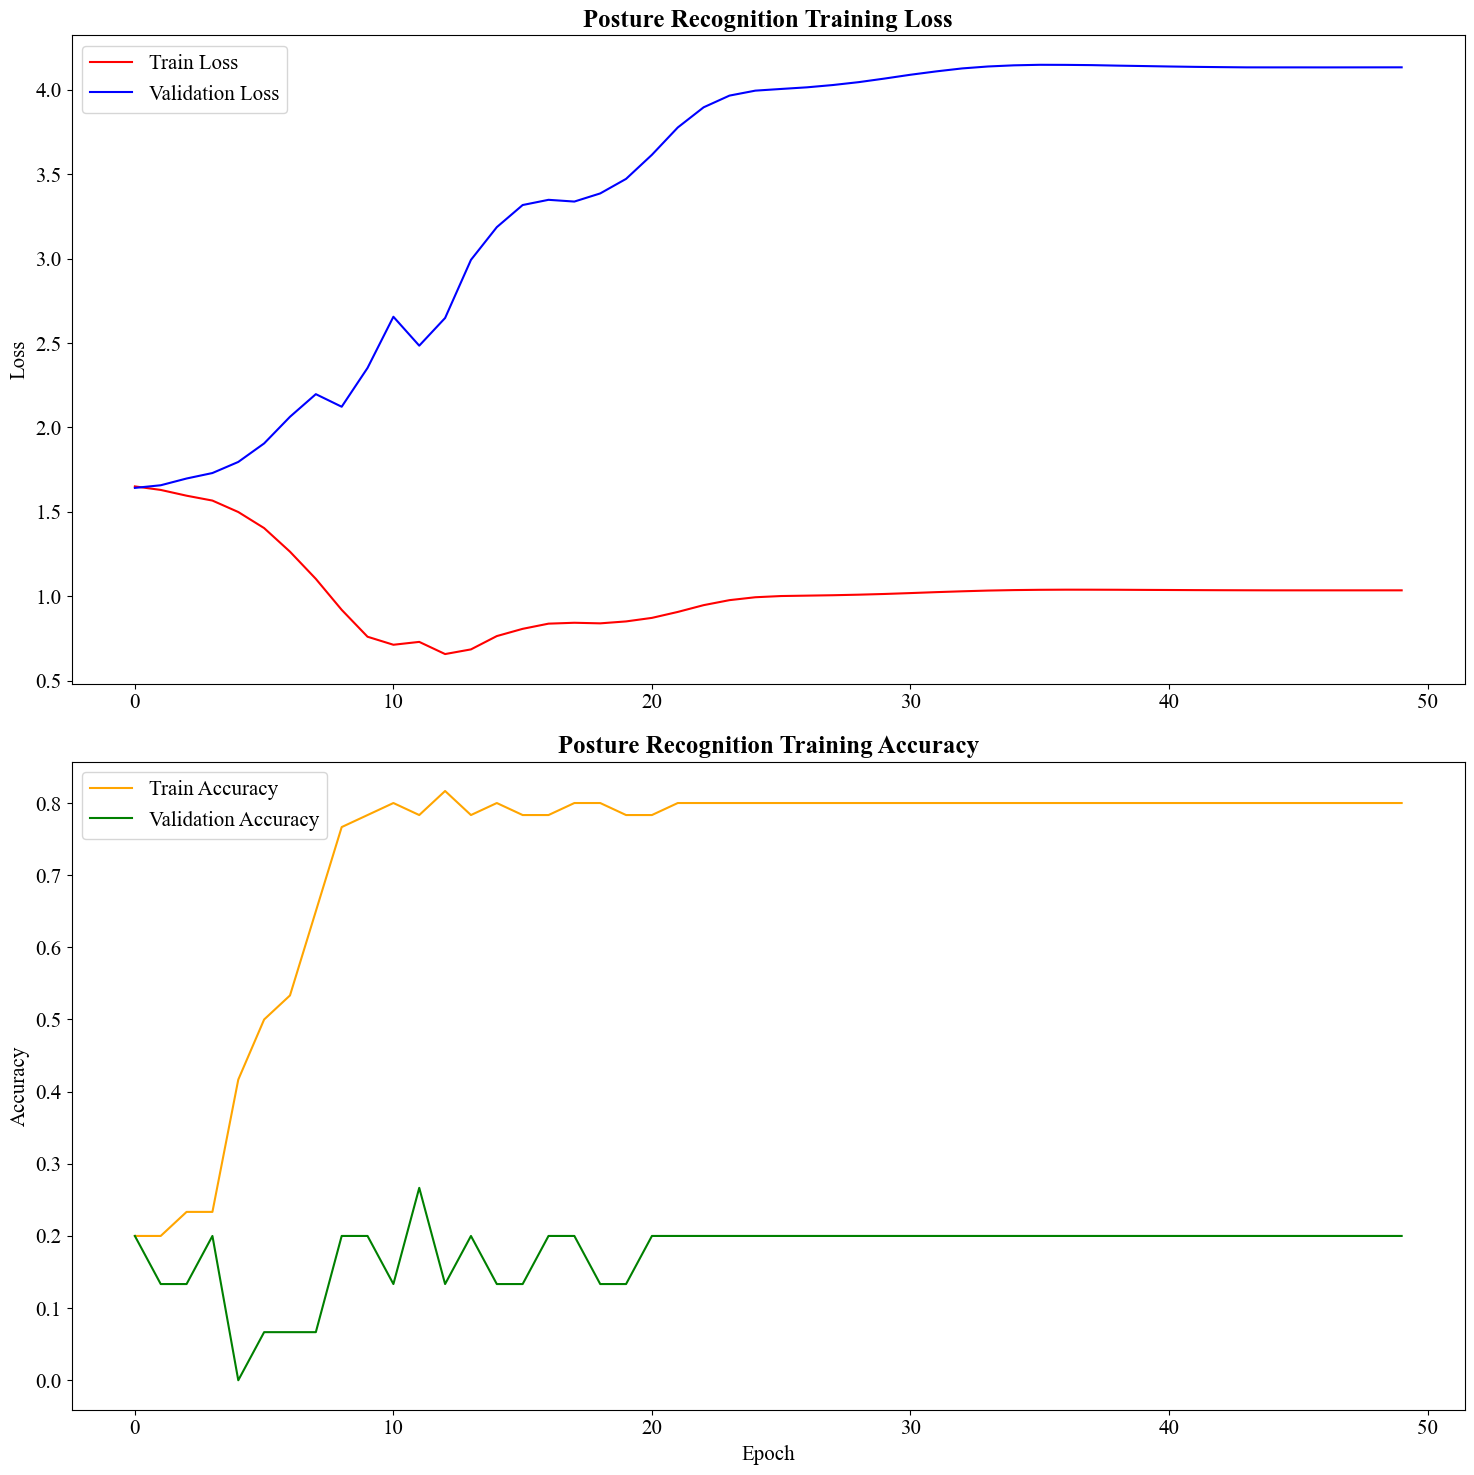

[INFO] Loading confusion matrix from: D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\experiments\video\20250514\videomae-base-finetuned-no-crop-no-aug\history_trainval.pkl


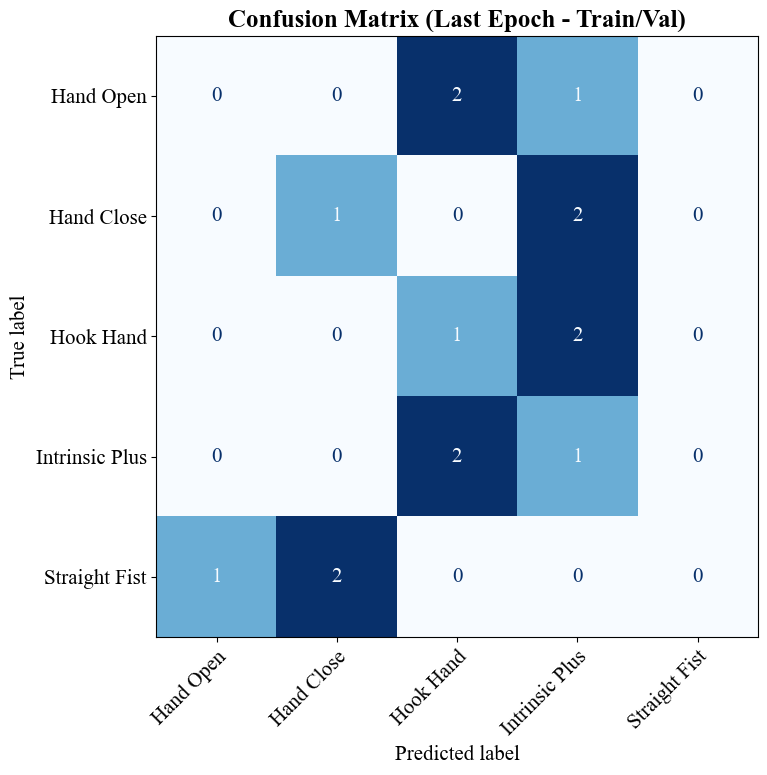

In [15]:
def visualize_train_val_losses(save_dir: str) -> None:
    import pickle
    import matplotlib.pyplot as plt
    import glob
    import os

    # Set global font properties
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 15

    # Search for history pickle files
    history_files = glob.glob(os.path.join(save_dir, "*.pkl"))

    for history_path in history_files:
        filename = os.path.basename(history_path)

        if "trainval" not in filename:
            continue  # skip non-trainval files

        print(f"Visualizing: {filename}")
        with open(history_path, "rb") as f:
            hist = pickle.load(f)

        fig, axs = plt.subplots(2, 1, figsize=(15, 15))

        # Plot loss
        axs[0].plot(hist["train_loss"], label="Train Loss", color='red')
        axs[0].plot(hist["eval_loss"], label="Validation Loss", color='blue')
        axs[0].set_title('Posture Recognition Training Loss', fontweight='bold')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        # Plot accuracy
        axs[1].plot(hist["train_accuracy"], label="Train Accuracy", color='orange')
        axs[1].plot(hist["eval_accuracy"], label="Validation Accuracy", color='green')
        axs[1].set_title('Posture Recognition Training Accuracy', fontweight='bold')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

def visualize_confusion_matrix(save_dir: str, mode: str = "trainval") -> None:
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay
    import glob
    import os

    # Look for the correct .pkl file based on mode
    history_files = glob.glob(os.path.join(save_dir, "*.pkl"))
    matched_file = None

    for file in history_files:
        if mode.lower() in os.path.basename(file).lower():
            matched_file = file
            break

    if not matched_file:
        print(f"[ERROR] No history file found in '{save_dir}' for mode '{mode}'")
        return

    print(f"[INFO] Loading confusion matrix from: {matched_file}")
    with open(matched_file, "rb") as f:
        hist = pickle.load(f)

    # Decide whether to use the last epoch or a single matrix
    if mode == "trainval":
        cm_data = hist["eval_confusion_matrix"][-1]
        title = "Confusion Matrix (Last Epoch - Train/Val)"
    else:
        cm_data = hist["eval_confusion_matrix"]
        title = f"Confusion Matrix ({mode.capitalize()})"

    cm = np.array(cm_data)
    class_names = [
        "Hand Open",
        "Hand Close",
        "Hook Hand",
        "Intrinsic Plus",
        "Straight Fist"
    ]

    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(title, fontweight="bold")

    plt.tight_layout()
    plt.show()

visualize_train_val_losses(r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\experiments\video\20250514\videomae-base-finetuned-no-crop-no-aug')
visualize_confusion_matrix(r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\experiments\video\20250514\videomae-base-finetuned-no-crop-no-aug', mode="trainval")